In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [2]:
file = "C:/Users/송이두/Desktop/가천대/2-1/인공지능개론/과제/data/AAME.csv"
data = pd.read_csv(file)

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,4.05,3.85,3.85,3.213167,15000
1,1980-03-18,0.0,4.00,3.80,3.80,3.171437,10200
2,1980-03-19,0.0,4.05,3.85,3.85,3.213167,33500
3,1980-03-20,0.0,4.00,3.80,3.80,3.171437,8700
4,1980-03-21,0.0,3.95,3.75,3.75,3.129709,12700


In [4]:
# 필요없는 컬럼 제거
dropped_data = data.drop(["Date", "Volume", "Adj Close"], axis=1)
print(dropped_data.shape)
dropped_data.head()

(10098, 4)


,Open,High,Low,Close
0,0.0,4.05,3.85,3.85
1,0.0,4.00,3.80,3.80
2,0.0,4.05,3.85,3.85
3,0.0,4.00,3.80,3.80
4,0.0,3.95,3.75,3.75


In [5]:
# Open == 0.0인 데이터 행 삭제

filtered_data = dropped_data[dropped_data['Open'] > 0.0]
print(filtered_data.shape)
filtered_data.head()

(8526, 4)


,Open,High,Low,Close
66,3.80,3.80,3.80,3.80
71,3.50,3.50,3.50,3.50
72,3.50,3.50,3.50,3.50
118,4.60,4.60,4.60,4.60
194,5.25,5.25,5.25,5.25


In [6]:
# 데이터를 array 형태로 변환
array_data = filtered_data.values
array_data.shape

(8526, 4)

In [7]:
# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(array_data)
scaled_data.shape

(8526, 4)

In [8]:
# 4개의 특징을 입력하여 다음 시점의 Close를 예측하기 위한 샘플 생성 
def make_sample(data, window, target_idx):
    train = []
    target = []
    for i in range(len(data)-window):
        train.append(data[i:i+window])
        target.append(data[i+window, target_idx])
    return np.array(train), np.array(target)

In [9]:
target_name = 'Close'
target_idx = dropped_data.columns.get_loc(target_name)
target_idx

3

In [10]:
window_size = 10
X, y = make_sample(scaled_data, window_size, target_idx)
X.shape, y.shape

((8516, 10, 4), (8516,))

In [11]:
# train, test, validation data 분리리
# 데이터의 시간 순서를 완벽히 보존하기 위해 직접 데이터 분리
total_samples = len(X)
train_ratio = 0.7 # 70% 훈련 데이터
val_ratio = 0.15 # 15% 검증 데이터
test_ratio = 0.15 # 15% 테스트 데이터 

# 비율에 따른 인덱스 계산
train_end_index = int(total_samples * train_ratio)
val_end_index = int(total_samples * (train_ratio + val_ratio))

# 훈련 데이터
X_train, y_train = X[:train_end_index], y[:train_end_index]

# 검증 데이터
X_val, y_val = X[train_end_index:val_end_index], y[train_end_index:val_end_index]

# 테스트 데이터
X_test, y_test = X[val_end_index:], y[val_end_index:]

# 데이터 shape 확인
print(f"X_train_indexed shape: {X_train.shape}, y_train_indexed shape: {y_train.shape}")
print(f"X_val_indexed shape: {X_val.shape}, y_val_indexed shape: {y_val.shape}")
print(f"X_test_indexed shape: {X_test.shape}, y_test_indexed shape: {y_test.shape}")

X_train_indexed shape: (5961, 10, 4), y_train_indexed shape: (5961,)
X_val_indexed shape: (1277, 10, 4), y_val_indexed shape: (1277,)
X_test_indexed shape: (1278, 10, 4), y_test_indexed shape: (1278,)


In [23]:
model = Sequential()
model.add(SimpleRNN(10, activation='tanh', input_shape=(window_size, 4)))
model.add(Dense(1, activation='tanh'))
model.compile(optimizer='adam', loss='mse')
model.summary()

C:\Users\송이두\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 10)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

print("\nSimpleRNN 모델 학습 시작...")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
print("SimpleRNN 모델 학습 완료.")


SimpleRNN 모델 학습 시작...
Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0240 - val_loss: 3.6671e-04
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 1.1896e-04
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.6771e-04 - val_loss: 7.6405e-05
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7154e-04 - val_loss: 7.3993e-05
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1616e-04 - val_loss: 9.3307e-05
SimpleRNN 모델 학습 완료.


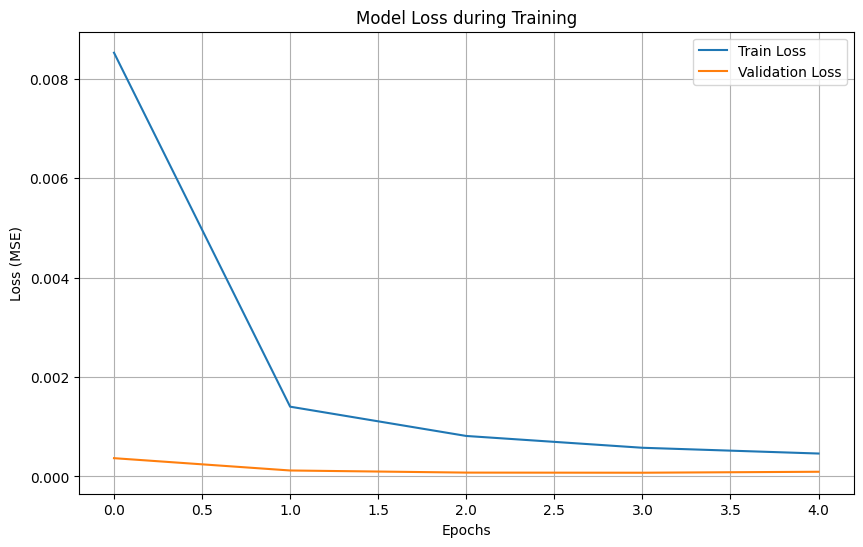

In [25]:
# 학습 과정의 손실 변화 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# 예측 수행
y_pred_scaled = model.predict(X_test)

# y_pred_scaled는 (n_samples, 1) 형태이므로, 2D 배열로 다시 reshape 필요
# 그러나 inverse_transform은 원래 입력 features 수와 동일한 컬럼 수를 요구
# 따라서 dummy 배열을 만들어서 Close 값만 역변환해야 합니다.

# Scaler는 4개의 피처를 가지고 fit 되었으므로, inverse_transform을 위해서는 4개의 피처를 가진 배열이 필요
# y_pred_scaled를 원래 스케일의 모든 피처 배열에 포함시키기 위한 더미 배열 생성
dummy_array = np.zeros((len(y_pred_scaled), scaled_data.shape[1]))
dummy_array[:, target_idx] = y_pred_scaled.flatten() # 예측값을 Close 컬럼 위치에 삽입

# 역변환
y_pred_original = scaler.inverse_transform(dummy_array)[:, target_idx]

# 실제 y_test 값도 역변환하여 비교 (만약 필요하다면)
dummy_y_test_array = np.zeros((len(y_test), scaled_data.shape[1]))
dummy_y_test_array[:, target_idx] = y_test.flatten()
y_test_original = scaler.inverse_transform(dummy_y_test_array)[:, target_idx]

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [27]:
mse_original_scale = mean_squared_error(y_test_original, y_pred_original)
print(f"MSE (Original Scale): {mse_original_scale:.4f}")

MSE (Original Scale): 0.0362
